# Harry Potter GPT

This is a GPT trained on the Harry Potter series by J.K. Rowling. In order to train the model, the entire text of all 7 books is encoded using OpenAI's tiktoken. This turns the text into a series of numerical tokens that can be interpreted by a model. 

The model itself is a decoder block transformer. The means it consists of a series of identical decoder blocks that process the input. These blocks are preceded by a positional embedding and learned token embedding layer. After all the blocks, there is the LM Head, which projects the output onto a distribution over the encoding vocabulary. The next token is sampled from this distribution. 

This isn't really a good demonstration of the model, as the dataset is relatively small and the model wasn't trained very long; however, it does learn a lot of text patterns after ~10k iterations of training. 

## Imports

In [1]:
import torch
from torch import nn, optim
from model import GPT
import matplotlib.pyplot as plt

## Load Text Data

In [2]:
full_text = ""
with open("harry_potter_series.txt", mode="r") as file:
    full_text += file.read()


## Tokenize Text Data

In [3]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt2")

In [4]:
assert(enc.decode(enc.encode("Hello World"))) == "Hello World", "Oops"
encoded_text = torch.tensor(enc.encode(full_text))
vocab_size = encoded_text.max() + 1
vocab_size

tensor(50256)

#### Helper Function For Text Batches

In [5]:
def get_batch(text, seq_len, device="mps", batch_size=1):
    start_indexes = torch.randint(len(text) - seq_len, (batch_size,)).numpy()
    prompts = torch.stack([text[index: index + seq_len] for index in start_indexes])
    targets = torch.stack([text[index + 1: index + seq_len + 1] for index in start_indexes])
    return prompts.to(device), targets.to(device)

## Define Model and Hyperparameters

In [6]:
device = "cuda"
batch_size = 64
sequence_length = 32
gpt = GPT(
    sequence_length=sequence_length,
    vocab_size=vocab_size,
    embedding_dim=512,
    num_heads=8,
    num_blocks=8,
    dropout=0,
    device=device
).to(device)

loss_history = []

gpt.load_state_dict(torch.load("model.pt", map_location=device))

In [7]:
optimizer = optim.AdamW(gpt.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [14]:
print(gpt.get_num_params())

76748880


## Function to generate a sample of text

In [46]:
def generate_text(x, k=1000, temp=1):
    prompt = torch.tensor(enc.encode("\n")).unsqueeze(0).to(device)
    for i in range(x):
        print(enc.decode([prompt.cpu().numpy()[0, -1]]), end="")
        prompt = gpt.generate(prompt, 1, k=k, temp=temp)
    print(enc.decode([prompt.cpu().numpy()[0, -1]]), end="")

## Train Model

In [29]:
iterations = 5000
gpt.train()
for iteration in range(iterations):
    prompts, targets = get_batch(encoded_text, sequence_length, batch_size=batch_size, device=device)
    logits = gpt(prompts)

    batch_size, sequence_length, vocab_size = logits.shape
    logits = logits.view(batch_size * sequence_length, vocab_size)
    targets = targets.view(batch_size * sequence_length)

    loss = criterion(logits, targets)
    gpt.zero_grad()
    loss.backward()
    optimizer.step()
    if iteration % 10 == 0:
        print(f"Iteration {iteration}/{iterations} | Loss: {loss.item()}")
        torch.save(gpt.state_dict(), "model.pt")
        loss_history.append(loss.item())
    if iteration % 250 == 0:
        print("\n_______________________________________________________________________")
        generate_text(100)
        print("\n_______________________________________________________________________\n")

Iteration 0/5000 | Loss: 4.227477073669434

_______________________________________________________________________
 
knum, most recent Order of those true, and Hermione, so creepy­ what?"
Someone spoke as though what now, for the restlessly chimney that his brain's eyes c weren't he saw

"
"Hi to laugh Bellat them in their savior and then said Ron. "Take your Britons diein, rather be no, the front of Potions' he could move like some thoughts itself across the necklace, then nobody does it perfectly. Meanwhile, Harry was
_______________________________________________________________________

Iteration 10/5000 | Loss: 4.173097610473633
Iteration 20/5000 | Loss: 4.260263919830322
Iteration 30/5000 | Loss: 4.121537685394287
Iteration 40/5000 | Loss: 4.104146480560303
Iteration 50/5000 | Loss: 4.0975341796875
Iteration 60/5000 | Loss: 4.211115837097168
Iteration 70/5000 | Loss: 4.145668983459473
Iteration 80/5000 | Loss: 4.234555244445801
Iteration 90/5000 | Loss: 4.176084995269775
Iterat

## Plot Loss History

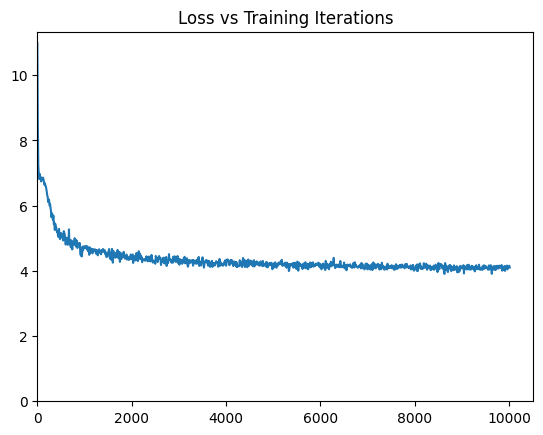

In [30]:
import numpy as np
x_axis = range(len(loss_history))
plt.plot(10 * np.array(x_axis), loss_history)
plt.ylim(0)
plt.xlim(0)
plt.title("Loss vs Training Iterations")
plt.show()

## Generate Text

In [66]:
generate_text(1000, k=100, temp=1)


Professor Dumbledore
"Why did not been there is back! ­"But a few to think, Harry could try on Hagrid, I have been to the door and out was all through a half its neck, you. "Roon velvet hat was a week. As I never looked into the only person in the common room only then he said Hagrid, they can't know what these longingly close ter do that your robes with another word. We know what I'll have got two squelps... all, as the window.
"No -"Well, as Ron muttered. A handsome scarlet robes, even the wizard of course it, the snake sloping so many hours, and Professor, and wizards would have a pair here.
"How darted toward them all. Weasley reached Snape��t reckon he'd have got
bend the edge of it too,
"Yeah, there was your way!"
"Yes, Harry.

"You want to me,"
She turned her shoulder, as though he turned grave.


"
"Thanks, and pointed it from the next to be here; he opened the very edge of Snape was going to take the way... there was his hand was even if you will they'll be back to go and Ron